In [3]:
from matplotlib.pyplot import *
import numpy as np
import pandas as pd
import os
from dataclasses import asdict
from copy import copy

from ATARI.syndat.particle_pair import Particle_Pair
from ATARI.syndat.experiment import Experiment
from ATARI.theory.resonance_statistics import make_res_par_avg
from ATARI.theory.xs import SLBW

import importlib

In [4]:
%matplotlib widget

### Generate a capture cross-section

The following code blocks use the ATARI/Syndat code to generate a synthetic or 'fake' set of resonance parameters for Ta-181. These resonance parameters correspond to a total, capture, and scattering cross-section that can be calculated with the imported SLBW function. The pointwise grid on which this cross-section is calculated is determined by the Experiment object. The exact set of resonance parameters can either be sampled randomly or explicitly defined.

In [5]:
ac=0.81271; M=180.948030; m=1; I=3.5; i=0.5; l_max=1     

E_min_max = [25, 100]
experiment_parameters = {'bw': {'val':0.1024,   'unc'   :   0},
                         'n':  {'val':0.067166,     'unc'   :0}}
exp = Experiment(E_min_max,  
                        experiment_parameters=experiment_parameters)

res_par_avg = make_res_par_avg(D_avg = 8.79, 
                            Gn_avg= 1.924, #0.658, 
                            n_dof = 1, 
                            Gg_avg = 64.0, 
                            g_dof = 10, 
                            print = False)

spin_groups = [ (3.0,1,0) ]
average_parameters = {'3.0':res_par_avg}
Ta_pair = Particle_Pair( ac, M, m, I, i, l_max,
                                input_options={},
                                spin_groups=spin_groups,
                                average_parameters=average_parameters )   

# resonance_ladder = Ta_pair.sample_resonance_ladder(energy_grid, spin_groups, average_parameters)

resonance_ladder = pd.DataFrame({"E":[31.8030900, 32.3453560, 43.3031830, 56.0645210, 63.9661590],
                                 "Gg":[54.9451300, 59.0939900, 59.7455500, 86.1347900, 67.1257900],
                                 "Gn":[0.3913400,0.0582700,2.9012500,2.1717400,0.0021400],
                                 "J":[3,3,3,3,3], "chs":[1,1,1,1,1], "lwave":[0,0,0,0,0], "J_ID":[1,1,1,1,1]})

print(resonance_ladder)

xs_tot, xs_scat, xs_cap = SLBW(exp.energy_domain, Ta_pair, resonance_ladder)
capture_df = pd.DataFrame({"E":exp.energy_domain, "theo_xs":xs_cap})
total_df = pd.DataFrame({"E":exp.energy_domain, "theo_xs":xs_tot})
capture_df

           E        Gg       Gn  J  chs  lwave  J_ID
0  31.803090  54.94513  0.39134  3    1      0     1
1  32.345356  59.09399  0.05827  3    1      0     1
2  43.303183  59.74555  2.90125  3    1      0     1
3  56.064521  86.13479  2.17174  3    1      0     1
4  63.966159  67.12579  0.00214  3    1      0     1


,E,theo_xs
0,100.000000,0.000636
1,99.919540,0.000639
2,99.839176,0.000641
3,99.758910,0.000644
4,99.678740,0.000646
...,...,...
2480,25.042254,0.011493
2481,25.032168,0.011473
2482,25.022088,0.011454
2483,25.012014,0.011434


Notice the E parameter of the resonance corresponds to the location on the x-axis. The Gn and Gg parameters roughly correspond to the width and height of the resonance.

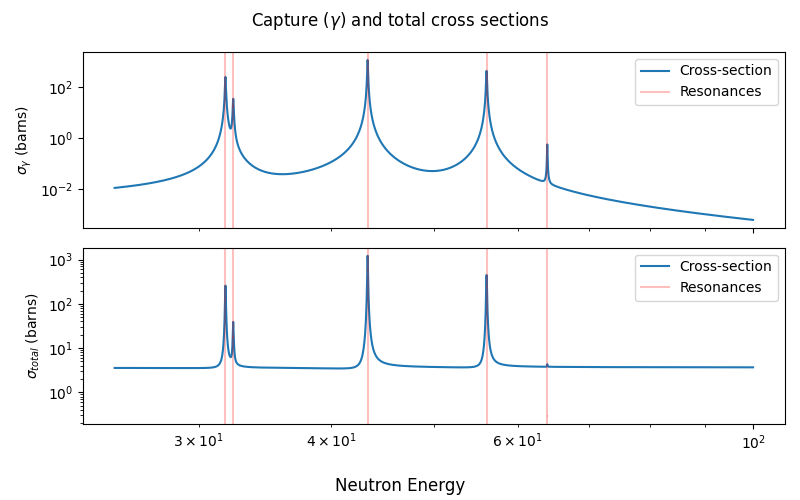

In [6]:

fig, ax = subplots(2,1, figsize=(8,5), sharex=True)
ax[0].plot(capture_df.E, capture_df.theo_xs)
ax[1].plot(total_df.E, total_df.theo_xs)

ax[0].set_ylabel(r'$\sigma_{\gamma}$ (barns)')
ax[1].set_ylabel(r'$\sigma_{total}$ (barns)')

for i, row in resonance_ladder.iterrows():
    _, _, max =  SLBW([row.E], Ta_pair, resonance_ladder)
    for a in ax:
        a.set_yscale('log')
        a.set_xscale('log')
        # a.set_xlabel('Neutron Energy')
        a.legend(["Cross-section", "Resonances"])

        a.axvline(row.E, color='r', alpha=0.25) #, label=f"Res: {i}")
        a.hlines(max.item()/2, xmin=row.E-(row.Gg+row.Gn)*1e-3, xmax=row.E+(row.Gg+row.Gn)*1e-3, alpha=0.25, color='r')

fig.supxlabel("Neutron Energy")
fig.suptitle(r"Capture ($\gamma$) and total cross sections")
fig.tight_layout()

# The Goal

In reality, we don't know what the *exact* resonance parameters (and therefore pointwise reaction cross-sections) are for Ta-181. Rather, we estimate them based on experimental measurement data. The overarching goal of the ATARI research group (Noah, Jake, & Oleksii) is to improve the method used to infer resonance parameters given measurement data. In order to aid in this development, we are using synthetically generated measurement data.

This allows us to know the true/exact parameters for a set of measurement data. Then, we can give feedback to our inference method(s) based on the known solutions. However, we want the synthetic data to be very realistic such that what we "learn" from it can be extrapolated to real measurement data. We have developed a methodology for how to do this and applied it to total cross-section data. We published a paper on this, the preprint can be found [here](https://arxiv.org/abs/2303.09698). Now, we want to apply a similar methodology to be able to *generate* realistic measurement data for capture cross-section experiments. In statistical/machine-learning lingo, we want to develop a *generative* model. A good resource for this method can be found [here](https://betanalpha.github.io/assets/case_studies/generative_modeling.html).

Ultimately we are sampling noise around the theoretical cross-section based on some probability density function (PDF). The most simple example of this would be to use a normal distribution (shown below) - though this would not be very realistic.

In [7]:
def get_data(theo_xs):
    unc_scale = 0.05
    data = abs(np.random.default_rng().normal(theo_xs, np.sqrt(theo_xs)*unc_scale ))
    data_unc = np.sqrt(data)*unc_scale
    return data, data_unc

data, data_unc = get_data(capture_df.theo_xs)
capture_df["exp"] = data
capture_df["exp_unc"] = data_unc


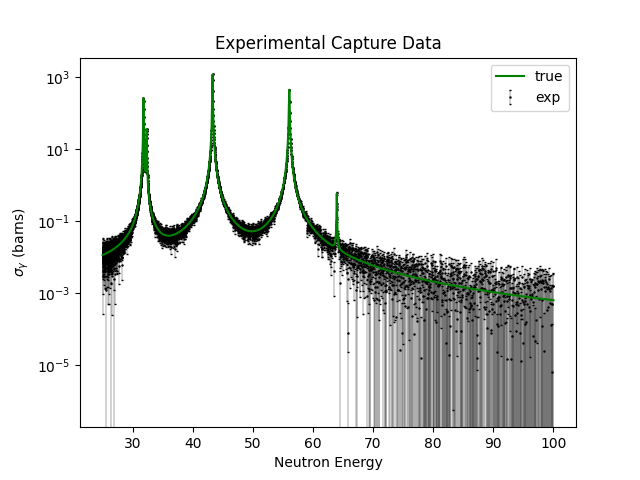

In [8]:

figure()
plot(capture_df.E, capture_df.theo_xs, ms=1, color='g', label='true')
errorbar(capture_df.E,capture_df.exp, yerr=capture_df.exp_unc, zorder=0, 
                                        fmt='.', color='k', linewidth=0.25, markersize=1.5, capsize=1, label='exp')

# ylim([-.1, 1])
yscale('log')
xlabel('Neutron Energy')
ylabel(r'$\sigma_{\gamma}$ (barns)')
title("Experimental Capture Data")
legend()

## How to think about the generative model from a statistical point of view

Unfortunately, the PDF for measurement data is not as simple as a normal distribution. The measurement data we want to replicate is a mathematical combination of several uncertain variables ($y_1, y_2, ... y_n$). Assuming just two uncertain variables for simplicity, the generative model we are after can be given as $\pi(y_1, y_2)$.

$\pi(y_1, y_2)$ is not known or simple. Instead, we take an approach called *ancestral* sampling. We know about the *process* by which a cross-section is measured, and we have a good idea of the PDFs for $y_1$ and $y_2$ independently. 

Therefore, we can construct a generative model like a narative or story like this:

$\pi(y_2|y_1)\pi(y_1)$

Where we can independently sample $y_2$ from $\pi(y_2|y_1)$ once we have a fixed value for $y_1$. That fixed value is sampled independently of $\pi(y_1)$.

## How to implement this for capture data

The capture cross-section is related to the capture yield (Y) by:

$Y = \frac{\sigma_{\gamma}}{\sigma_{total}} (1-e^{-n\sigma_{total}}) $

In this equation, each variable is actually a vector in incident neutron energy or time-of-flight.
The nonrelativistic relationship between the two is given by:

$ E = \frac{1}{2}mv^2 = \frac{1}{2} m (\frac{FP}{ToF})^{2} $ 

For now, we will keep these parameters as vectors in energy.
Next, capture yield is related to detector count rates (the actually observables we are after) by:

$Y = \frac{\dot{c}_{\gamma} - \dot{c}_{bg}} {\phi} $

Here, the $\phi$ term is simplified, but it describes the incident neutron flux on the target. 
Let's assume for now that it is a function constant in energy with a value of 1000.
Let's also assume that $\dot{c}_{bg}$ is a function constant in energy with a value of 25.

Given these values for $\phi$ and $\dot{c}_{bg}$, you can calculate an expected or theoretical count rate ($\dot{c}_{\gamma, theo}$) that corresponds to the cross-section (or resonance parameters) calculated previously in the notebook.


<!-- Other variables we may need in the future -->
<!-- | trigo     |      9758727              |   0                         |   -->
<!-- | trigs     |      18476117             |   0                         |   -->
<!-- | t0        |      3.32                 |   0                         |   -->
<!-- | bw        |      0.006                |   0                         |   -->
<!-- | m1        |      1                    |   0.016                     |       -->
<!-- | m2        |      1                    |   0.008                     |       -->
<!-- | m3        |      1                    |   0.018                     |       -->
<!-- | m4        |      1                    |   0.005                     |       -->    
<!-- | ks        |      0.56                 |   0.02402339737495515       |                   -->
<!-- | ko        |      1.47                 |   0.05576763648617445       |                   -->
<!-- | b0s       |      9.                   |   0.1                       |   -->
<!-- | b0o       |      13.                  |   0.7                       |   -->


Once you have an expected count rate, $\dot{c}_{\gamma, theo}$, apply a Poisson counting statistics noise model to get a noisy or experimental count rate:

$ \dot{c}_{\gamma, exp} ~ P(\lambda = \dot{c}_{\gamma, theo}) $

The uncertainty on the experimental count rate can then be inferred as:

$ \delta \dot{c}_{\gamma, exp} \approxeq \sqrt{\dot{c}_{\gamma, exp} } $

Make a plot of the expected and experimental count rates.

Next, take $\dot{c}_{\gamma, exp}$ and calculate a noisy, experimental capture yeild, $Y_{exp}$ and plot this data alongside the theoretical value.

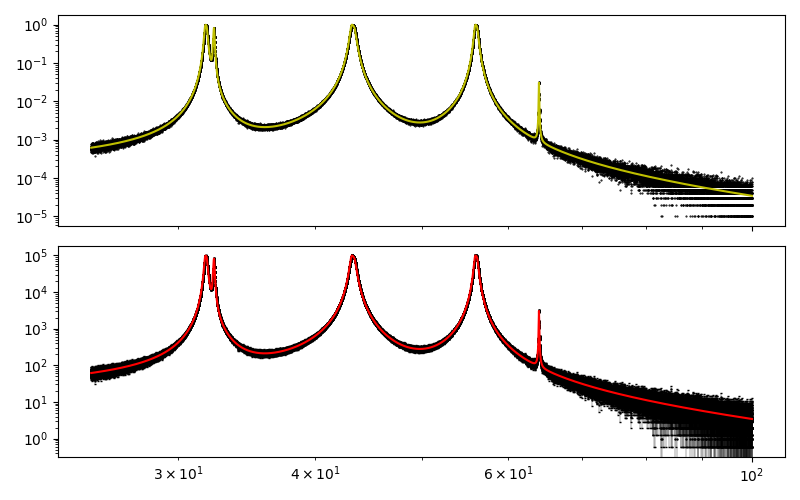

In [13]:
n=0.06
count_rate_background=0
neutron_flux=100000
sample_volume=20


capture_df["yield_theo"]=(capture_df.theo_xs/total_df.theo_xs)*(1-np.exp(-n*total_df.theo_xs))
capture_df["count_theo"]=capture_df.yield_theo*neutron_flux+count_rate_background

def Poisson_dis(mean):
    noisy_count_rate=np.random.poisson(mean,sample_volume)
    uncertainty_count_rate=np.sqrt(noisy_count_rate)
    return(noisy_count_rate,uncertainty_count_rate)

count_exp=np.empty([len(capture_df.count_theo),sample_volume])
count_exp_uncertainty=np.empty([len(capture_df.count_theo),sample_volume])
Count_E=np.empty_like(count_exp)

for idx,x in enumerate(capture_df.count_theo):
    count_exp[idx],count_exp_uncertainty[idx]=Poisson_dis(x)
    Count_E[idx]=np.ones(sample_volume)*capture_df.E[idx]

yield_exp=np.divide(count_exp-count_rate_background,neutron_flux)


fig, ax = subplots(2,1, figsize=(8,5), sharex=True)
ax[0].plot(capture_df.E, capture_df.yield_theo,"y")
ax[0].scatter(Count_E.flatten(),yield_exp.flatten(), c='k',s=1,marker=".")
ax[0].set_yscale('log')
ax[0].set_xscale('log')

ax[1].plot(total_df.E, capture_df.count_theo,"r")
#ax[1].errorbar(Count_E.flatten(),count_exp.flatten(),yerr=count_exp_uncertainty.flatten(),zorder=0, fmt='.', color='k', linewidth=0.25, markersize=1.5, capsize=1, label='exp')
ax[1].scatter(Count_E.flatten(),count_exp.flatten(), c='k',s=1,marker=".")
ax[1].set_yscale('log')
ax[1].set_xscale('log')
fig.tight_layout()

## Next steps

The novel part of this is over. An expected and noisy experimental observable has been generated from a known cross-section (or set of resonance parameters).
Then, that noisy observable was *reduced* back to a noisy version of the object we want, capture yield. 
I don't expect you to get to these next steps before a discussion with me, but I wanted to give some idea on where we're taking this.

The next steps basically take the workflow above to full fidelity as follows:

1. In the calculation of $\dot{c}_{\gamma, theo}$, we were effectively assuming $\phi$ and $\dot{c}_{bg}$ were the true/exact values. In reality, these are just experimental estimates of the true value. To reflect this in our generative model, these parameters should be randomly sampled based on their uncertainty before calculating $\dot{c}_{\gamma, theo}$. In other words, $\dot{c}_{\gamma, theo}$ is a function of $\phi_{theo}$ and $\dot{c}_{bg, theo}$. Because these values are not known exactly, we randomly sample them based on estimates and uncertainties and then take that sampled value as fixed and true. 
<!-- This is mathematically described below with the subscript $theo$ indicating that a value is assumed to be the true underlying value. -->

2. In the data reduction process, where $\dot{c}_{\gamma, exp}$ is converted to $Y_{exp}$. Experimental uncertainties should be propagated through that operation. 
That is, uncertainties on both $\dot{c}_{\gamma, exp}$, $\phi$, and $\dot{c}_{bg}$. This is often done using linear error propagation. If you've taken NE401, I think its "equation 2.84 in the text"... this was drilled into my brain during that class... 

3. Lastly, $\phi$, and $\dot{c}_{bg}$ are oversimplified as I mentioned before. We can discuss how these are actually experimentally measured and how to include that later.



<!-- Given the following estimates for the unknown scalar variables and ignoring their uncertainty for now, calculate the expected or theoretical $\dot{c}_{\gamma, theo}$ from the set of resonance parameters defined previously in this notebook.

| Variable          |  Value                    | Uncertainty                 |
| ------------------|---------------------------|-----------------------------|
| n                 |      0.06716              |   0                         |  
| FP                |      35.18                |   0                         |  
| a                 |      582.776859458071     |   $\sqrt{1.14395753^3}$     |                      
| b                 |      0.0514968909620919   |   $\sqrt{2.19135003^{-5}}$  |                          
| ab covariance     |      1.426599221          |   None                      |  
 exponential function wrt time-of-flight:

$\dot{c}_{bg} = a e^{ToF -b}$ -->
